In [26]:
from torch import nn
import torch

In [27]:
# 一些基础的函数，类似于gnn中常用的小模块，小trick
def unsorted_segment_sum(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)


def get_edges(n_nodes):
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                rows.append(i)
                cols.append(j)

    edges = [rows, cols]
    return edges

def get_edges_batch(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = torch.ones(len(edges[0]) * batch_size, 1)
    edges = [torch.LongTensor(edges[0]), torch.LongTensor(edges[1])]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [torch.cat(rows), torch.cat(cols)]
    return edges, edge_attr

In [28]:
import torch
import torch.nn as nn

class phi_e(nn.Module):
    def __init__(self, input_edge, hidden_nf, act_fn):
        super(phi_e, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_edge, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn
        )
        
    def forward(self, x):
        return self.mlp(x)


class phi_h(nn.Module):
    def __init__(self, input_nf, hidden_nf, output_nf, act_fn):
        super(phi_h, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_nf + hidden_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf),
            act_fn
        )
    
    def forward(self, x):
        return self.mlp(x)


class phi_x(nn.Module):
    def __init__(self, hidden_nf, act_fn, tanh):
        super(phi_x, self).__init__()
        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
        
        modules = []
        modules.append(nn.Linear(hidden_nf, hidden_nf))
        modules.append(act_fn)
        modules.append(layer)
        
        if tanh:
            modules.append(nn.Tanh())
        
        self.mlp = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.mlp(x)

class phi_v(nn.Module):
    def __init__(self, hidden_nf, act_fn, tanh=True):
        super(phi_v, self).__init__()
        
        # init
        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
        
        modules = []
        # 后期需要修正
        modules.append(nn.Linear(hidden_nf, hidden_nf))
        modules.append(act_fn)
        modules.append(layer)
        
        if tanh:
            modules.append(nn.Tanh())
        
        self.mlp = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.mlp(x)



# 定义Attention MLP模块
class AttMLP(nn.Module):
    def __init__(self, hidden_nf):
        super(AttMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_nf, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.mlp(x)

In [29]:
class Equivariant_Graph_Operator(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, nodes_att_dim=0, act_fn=nn.ReLU(), residual=False, attention=False, normalize=False, coords_agg='mean', velocity_agg = 'sum', tanh=False):
        super(Equivariant_Graph_Operator, self).__init__()
        
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.coords_agg = coords_agg
        self.velocity_agg = velocity_agg
        self.tanh = tanh
        self.epsilon = 1e-8 # 数值稳定性
        input_edge = input_nf * 2
        edges_coors_nf = 1 # 边坐标特征的数量
        
        edges_speed_nf = 1 # 速度差的特征数量
        self.edge_mlp = phi_e(input_edge + edges_coors_nf + edges_in_d + edges_speed_nf, hidden_nf, act_fn)
        
        #self.edge_mlp = phi_e(input_edge + edges_coors_nf + edges_in_d, hidden_nf, act_fn)
        self.node_mlp = phi_h(input_nf, hidden_nf, output_nf, act_fn)
        self.coord_mlp = phi_x(hidden_nf, act_fn, tanh)
        
        # 在Equivariant_Graph_Operator中的初始化部分：
        self.velocity_mlp = phi_v(hidden_nf, act_fn, tanh)
        
        self.coord_mlp_vel = nn.Sequential(
            nn.Linear(input_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, 1))
        
        if self.attention:
            self.att_mlp = AttMLP(hidden_nf)
            
    # 更新速度信息
    def velocity_model(self, velocity, edge_index, velocity_diff, edge_feat):
        row, col = edge_index
        trans = velocity_diff * self.velocity_mlp(edge_feat) # 这里的velocity_mlp需要你定义，它类似于coord_mlp，但是为速度特性定制
        if self.velocity_agg == 'sum':  # 这里的velocity_agg表示速度聚合方式，可以选择 'sum' 或 'mean'
            agg = unsorted_segment_sum(trans, row, num_segments=velocity.size(0))
        elif self.velocity_agg == 'mean':
            agg = unsorted_segment_mean(trans, row, num_segments=velocity.size(0))
        else:
            raise Exception('Wrong velocity_agg parameter' % self.velocity_agg)
        velocity = velocity + agg
        return velocity

    # 增加一个函数来计算速度的欧几里得距离
    def speed2distance(self, speed_index, speed):
        row, col = speed_index
        speed_diff = speed[row] - speed[col]
        distance = torch.sum(speed_diff ** 2, 1).unsqueeze(1)
        return distance, speed_diff


    # 修改 edge_model 函数
    def edge_model(self, source, target, radial, speed_distance, edge_attr):
        if edge_attr is None:
            out = torch.cat([source, target, radial, speed_distance], dim=1)
        else:
            out = torch.cat([source, target, radial, speed_distance, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    
    # 更新节点特征，类比于在论文中更新 hl+1, 其中row[i]和col[i]表示图中一条从row[i]节点到col[i]节点的边。
    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index 
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        if self.residual:
            out = x + out
        
        return out, agg
    
    # 更新坐标信息
    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat) # 对应方程4的后部分，也就是未聚合的部分
        if self.coords_agg == 'sum':
            agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        elif self.coords_agg == 'mean':
            agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        else:
            raise Exception('Wrong coords_agg parameter' % self.coords_agg)
        coord = coord + agg
        return coord

    
    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff ** 2, 1).unsqueeze(1)

        if self.normalize:
            norm = torch.sqrt(radial).detach() + self.epsilon
            coord_diff = coord_diff / norm
        return radial, coord_diff
    

    
    def forward(self, h, edge_index, coord, speed, edge_attr=None, node_attr=None):
        # 节点坐标之间的径向差异和坐标差
        radial, coord_diff = self.coord2radial(edge_index, coord)

        # 速度矢量之间的欧几里得距离
        speed_distance, speed_diff = self.speed2distance(edge_index, speed)

        # 根据新的边模型计算边特征
        edge_feat = self.edge_model(h[edge_index[0]], h[edge_index[1]], radial, speed_distance, edge_attr)
        
        # 更新速度信息
        speed = self.velocity_model(speed, edge_index, speed_diff, edge_feat)

        # 更新坐标信息
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat) + self.coord_mlp_vel(h) * speed
        
        # 更新节点特征
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)

        return h, coord, speed

In [36]:
#等变性验证
from e3nn import o3
import torch
from torch import nn
import torch.nn.functional as F

# 随机生成旋转矩阵
rot = o3.rand_matrix()

# 初始化虚拟变量
batch_size = 1
n_nodes = 100
n_feat = 3
x_dim = 3
v_dim = 3
h = torch.randn(batch_size *  n_nodes, n_feat)
x = torch.randn(batch_size * n_nodes, x_dim)
v = torch.randn(batch_size * n_nodes, v_dim)
edges, edge_attr = get_edges_batch(n_nodes, batch_size)


EGO = Equivariant_Graph_Operator(3, 3, 32)

# 测试等变性
# 先传递通过模型
h1, x1, v1 = EGO(h, edges, x, v)
print(h1.shape, x1.shape, v1.shape)

# 旋转并传递通过模型
h_rot, x_rot, v_rot = EGO(h, edges, x @ rot, v@ rot)

# 旋转模型的初始输出
h1_rot = h1 @ rot
x1_rot = x1 @ rot
v1_rot = v1 @ rot

# 检查网络是否等变
print("h1\n", h1)
print("h1 @ rot\n", h1_rot)
print("h_rot\n", h_rot)

print("x1\n", x1)
print("x1 @ rot\n", x1_rot)
print("x_rot\n", x_rot)

print("v1\n", v1)
print("v1 @ rot\n", v1_rot)
print("v_rot\n", v_rot)

print("Are h1 @ rot and h_rot close?", torch.allclose(h1_rot, h_rot, atol=1e-20))
print("Are x1 @ rot and x_rot close?", torch.allclose(x1_rot, x_rot, atol=1e-20))
print("Are v1 @ rot and v_rot close?", torch.allclose(v1_rot, v_rot, atol=1e-20))

torch.Size([100, 3]) torch.Size([100, 3]) torch.Size([100, 3])
h1
 tensor([[ 7.5942,  5.6340,  0.0000],
        [ 8.0494, 10.3949,  0.0000],
        [20.3374, 18.8446,  0.0000],
        [ 7.6870,  4.3904,  0.0000],
        [10.3893, 10.5389,  0.0000],
        [ 9.7344, 10.0099,  0.0000],
        [ 6.0976,  6.2926,  0.0000],
        [10.5090,  6.4934,  0.0000],
        [ 8.8020,  5.3331,  0.0000],
        [14.7017,  9.8890,  0.0000],
        [ 7.5424,  8.5357,  0.0000],
        [ 8.7643,  5.1697,  0.0000],
        [ 8.6980, 10.8650,  0.0000],
        [13.1798,  8.5916,  0.0000],
        [ 6.4991,  5.8666,  0.0000],
        [ 6.8546,  3.5448,  0.0000],
        [ 5.0503,  6.1824,  0.0000],
        [ 7.0159,  4.7368,  0.0000],
        [13.7557,  9.3956,  0.0000],
        [ 9.4861,  5.8784,  0.0000],
        [ 4.7751,  6.9358,  0.0000],
        [ 5.9867,  9.1619,  0.0000],
        [ 4.5962,  6.9125,  0.0000],
        [14.2256, 10.7181,  0.0000],
        [ 8.4144,  6.5293,  0.0000],
        

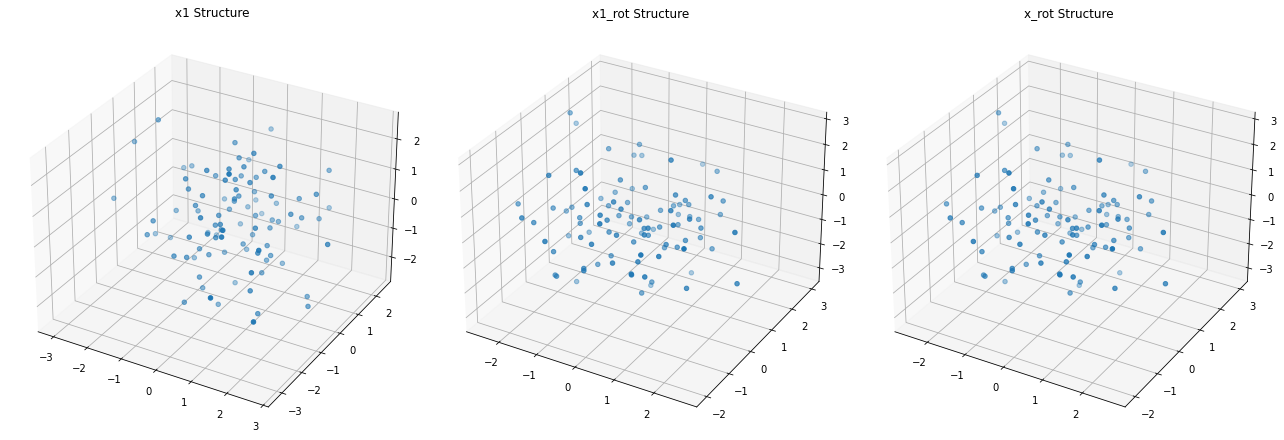

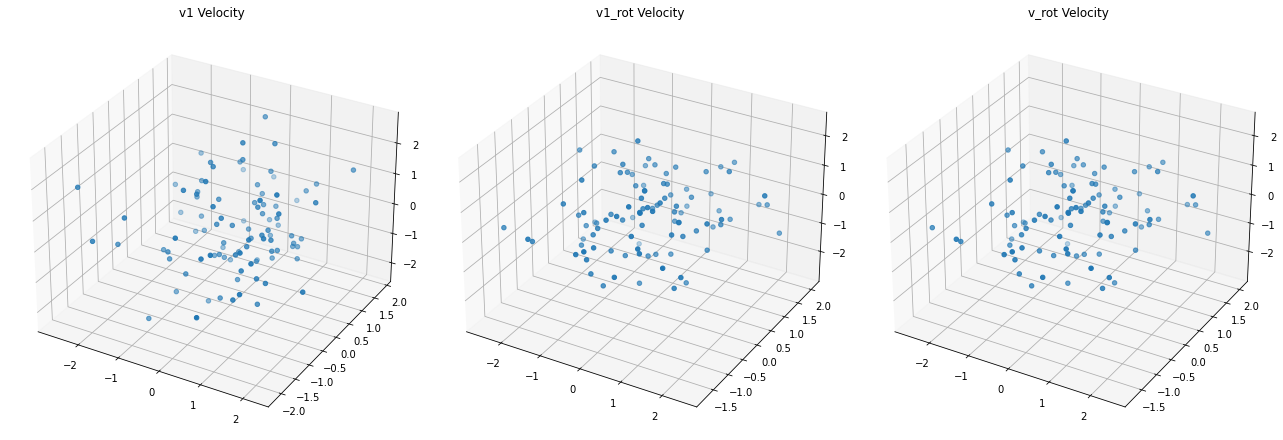

In [37]:
import matplotlib.pyplot as plt

def plot_3d_structures_in_row(coords_list, titles):
    """Visualize multiple 3D coordinates side by side using matplotlib."""
    n_plots = len(coords_list)
    fig = plt.figure(figsize=(n_plots*6, 6))
    
    for idx, (coords, title) in enumerate(zip(coords_list, titles)):
        ax = fig.add_subplot(1, n_plots, idx+1, projection='3d')
        coords_np = coords.detach().numpy()
        ax.scatter(coords_np[:, 0], coords_np[:, 1], coords_np[:, 2])
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# Reshape outputs for visualization
x1_reshaped = x1.reshape(batch_size, n_nodes, x_dim)
x_rot_reshaped = x_rot.reshape(batch_size, n_nodes, x_dim)
x1_rot_reshaped = x1_rot.reshape(batch_size, n_nodes, x_dim)

v1_reshaped = v1.reshape(batch_size, n_nodes, v_dim)
v_rot_reshaped = v_rot.reshape(batch_size, n_nodes, v_dim)
v1_rot_reshaped = v1_rot.reshape(batch_size, n_nodes, v_dim)

# Visualize x1, x1_rot, and x_rot
coords_list_x = [x1_reshaped[0], x1_rot_reshaped[0], x_rot_reshaped[0]]
titles_x = ["x1 Structure", "x1_rot Structure", "x_rot Structure"]
plot_3d_structures_in_row(coords_list_x, titles_x)

# Visualize v1, v1_rot, and v_rot
coords_list_v = [v1_reshaped[0], v1_rot_reshaped[0], v_rot_reshaped[0]]
titles_v = ["v1 Velocity", "v1_rot Velocity", "v_rot Velocity"]
plot_3d_structures_in_row(coords_list_v, titles_v)


In [34]:
import torch
import math

# 创建一个形状为 torch.Size([3, 2]) 的示例张量
tensor = torch.rand(3, 2)

# 定义旋转角度（例如，45度）
angle = math.radians(45)  # 将角度转换为弧度

# 创建旋转矩阵
rotation_matrix = torch.tensor([
    [math.cos(angle), -math.sin(angle)],
    [math.sin(angle), math.cos(angle)]
])

# 对张量进行旋转
rotated_tensor = torch.mm(tensor, rotation_matrix.T)  # 转置矩阵用于反向旋转

print(rotated_tensor.shape)

torch.Size([3, 2])


torch.Size([3, 2])


In [32]:
class Equivariant_Graph_Network_Vector(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, device='cpu', act_fn=nn.SiLU(), n_layers=4, coords_weight=1.0, recurrent=False, norm_diff=False, tanh=False):
        super(Equivariant_Graph_Network_Vector, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, Equivariant_Graph_Operator(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=0, act_fn=nn.SiLU(), residual=False, attention=False, normalize=False, coords_agg='mean', velocity_agg = 'sum', tanh=False))
        #self.to(self.device)


    def forward(self, h, x, edges, vel):
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, coord, velocity = self._modules["gcl_%d" % i](h, edges, x, vel, edge_attr=None)
        return h, coord, velocity

In [33]:
#等变性验证
from e3nn import o3
import torch
from torch import nn
import torch.nn.functional as F

# 随机生成旋转矩阵
rot = o3.rand_matrix()

# 初始化虚拟变量
batch_size = 1
n_nodes = 3
n_feat = 3
x_dim = 3
v_dim = 3
h = torch.randn(batch_size *  n_nodes, n_feat)
x = torch.randn(batch_size * n_nodes, x_dim)
v = torch.randn(batch_size * n_nodes, x_dim)
edges, edge_attr = get_edges_batch(n_nodes, batch_size)


EGO = Equivariant_Graph_Network_Vector(3, 1, 3)
h1, x1, v1 = EGO(h, x, edges, v)

# 旋转并传递通过模型
h_rot, x_rot, v_rot = EGO(h, x @ rot, edges, v@ rot)

# 旋转模型的初始输出
h1_rot = h1 @ rot
x1_rot = x1 @ rot
v1_rot = v1 @ rot

# 检查网络是否等变
print("h1\n", h1)
print("h1 @ rot\n", h1_rot)
print("h_rot\n", h_rot)

print("x1\n", x1)
print("x1 @ rot\n", x1_rot)
print("x_rot\n", x_rot)

print("v1\n", v1)
print("v1 @ rot\n", v1_rot)
print("v_rot\n", v_rot)

print("Are h1 @ rot and h_rot close?", torch.allclose(h1_rot, h_rot, atol=1e-20))
print("Are x1 @ rot and x_rot close?", torch.allclose(x1_rot, x_rot, atol=1e-20))
print("Are v1 @ rot and v_rot close?", torch.allclose(v1_rot, v_rot, atol=1e-20))

h1
 tensor([[0.0215, 0.0695, 0.3483],
        [0.0536, 0.1052, 0.4055],
        [0.0716, 0.1260, 0.4372]], grad_fn=<SiluBackward0>)
h1 @ rot
 tensor([[-0.2697, -0.0082, -0.2320],
        [-0.2974, -0.0274, -0.2986],
        [-0.3127, -0.0390, -0.3360]], grad_fn=<MmBackward0>)
h_rot
 tensor([[0.0215, 0.0695, 0.3483],
        [0.0536, 0.1052, 0.4055],
        [0.0716, 0.1260, 0.4372]], grad_fn=<SiluBackward0>)
x1
 tensor([[ 0.1721,  0.1343,  0.4917],
        [-0.9805,  0.3637,  0.7695],
        [-0.1801,  0.4648, -0.9829]], grad_fn=<AddBackward0>)
x1 @ rot
 tensor([[-0.2976, -0.0187, -0.4478],
        [-1.2034, -0.4242,  0.2403],
        [ 0.6830, -0.6399,  0.5818]], grad_fn=<MmBackward0>)
x_rot
 tensor([[-0.2976, -0.0187, -0.4478],
        [-1.2034, -0.4242,  0.2403],
        [ 0.6830, -0.6399,  0.5818]], grad_fn=<AddBackward0>)
v1
 tensor([[-0.1634,  1.5621,  0.2717],
        [-0.1132, -0.1553, -0.8902],
        [ 0.2083, -0.1706,  1.5718]], grad_fn=<AddBackward0>)
v1 @ rot
 tensor([[-

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>